#Data Loading

In [24]:
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Research/Challenge 2021/IC-late-2021/Dataset/accelerometer_train.csv')
df_train.head(5)

,segment_id,time_elapsed,x,y,z
0,0.0,0.006,-2.681,-9.423,0.025
1,0.0,0.826,-2.604,-9.423,0.029
2,0.0,2.036,-2.988,-9.079,0.237
3,0.0,2.046,-2.988,-9.079,0.237
4,0.0,2.236,-2.566,-8.581,0.243


In [5]:
label_train = pd.read_csv('/content/drive/MyDrive/Research/Challenge 2021/IC-late-2021/Dataset/activities_train.csv')
label_train.head(5)

,subject,segment_id,activity_id
0,2,0,6
1,2,56,12
2,2,67,12
3,2,85,2
4,2,99,3


#Data Prepocessing

In [7]:
df_train = df_train.interpolate(method='nearest')
df_train = df_train.drop_duplicates()

#Segmentation

In [33]:
train_seg_list = []
train_label_list = []
for seg_id in df_train['segment_id'].unique():
  temp = df_train[df_train['segment_id']==seg_id]
  label = label_train[label_train['segment_id']==seg_id]['activity_id'].values

  train_seg_list.append(temp)
  train_label_list.append(int(label))

In [34]:
print(len(train_label_list))
print(len(train_seg_list))

277
277


#Feature Extraction

In [68]:
from scipy.signal import find_peaks
import scipy.stats

In [70]:
def get_features(x_data):
    #Set features list
    features = []
    #Set columns name list
    DFclist=list(x_data.columns)

    #Calculate features (STD, Average, Max, Min) for each data columns X Y Z 
    for k in DFclist:
        # std
        features.append(x_data[k].std(ddof=0))
        # avg
        features.append(np.average(x_data[k]))
        # max
        features.append(np.max(x_data[k]))
        # min
        features.append(np.min(x_data[k]))
        
        #Quynh features
        features.append(np.argmin(x_data[k]))
        features.append(np.argmax(x_data[k]))
        features.append(len(find_peaks(x_data[k])[0]))

        #Min features
        features.append(np.var(x_data[k]))
        features.append(np.mean(x_data[k]))
        scipy.stats.skew(x_data[k], axis=0, bias=True, nan_policy='propagate')
        scipy.stats.kurtosis(x_data[k], axis=0, fisher=True, bias=True, nan_policy='propagate')
    return features

In [71]:
features_list = []

for seg in train_seg_list:
  #Drop 2 columns 'subject_id' and 'datetime', we only use 3 columns x, y, z
  seg = seg.drop(columns=['time_elapsed','segment_id'])
  features_list.append(get_features(seg))


#Model Training

In [72]:
from sklearn.ensemble import RandomForestClassifier  

In [73]:
X_train = features_list
y_train = train_label_list

In [74]:
model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)
model_ml.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

#Testing

In [52]:
df_test = pd.read_csv('/content/drive/MyDrive/Research/Challenge 2021/IC-late-2021/Dataset/accelerometer_test.csv')
label_test = pd.read_csv('/content/drive/MyDrive/Research/Challenge 2021/IC-late-2021/Dataset/activities_test.csv')

In [53]:
df_test = df_test.interpolate(method='nearest')
df_test = df_test.drop_duplicates()

In [75]:
test_seg_list = []
test_label_list = []
for seg_id in df_test['segment_id'].unique():
  temp = df_test[df_test['segment_id']==seg_id]
  label = label_test[label_test['segment_id']==seg_id]['activity_id'].values

  test_seg_list.append(temp)
  test_label_list.append(int(label))

In [76]:
test_features_list = []

for seg in test_seg_list:
  #Drop 2 columns 'subject_id' and 'datetime', we only use 3 columns x, y, z
  seg = seg.drop(columns=['time_elapsed','segment_id'])
  test_features_list.append(get_features(seg))


In [77]:
X_test = test_features_list
y_test = test_label_list

In [78]:
y_predict = model_ml.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [80]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           2       0.74      0.85      0.79        20
           3       0.54      0.75      0.63        20
           4       0.46      0.35      0.40        17
           6       1.00      0.50      0.67        14
           9       0.75      0.64      0.69        14
          12       0.67      0.71      0.69        31

    accuracy                           0.66       116
   macro avg       0.69      0.63      0.64       116
weighted avg       0.68      0.66      0.65       116



In [81]:
cm = confusion_matrix(y_test,y_predict)

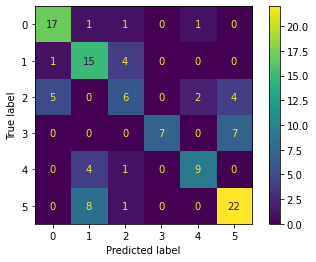

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()